<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [93]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [94]:
!chcp 65001

Active code page: 65001


In [95]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [97]:
# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

import urllib.request

url_bg = "https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip"
url_eval = "https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip"

urllib.request.urlretrieve(url_bg, "images_background.zip")
urllib.request.urlretrieve(url_eval, "images_evaluation.zip")

('images_evaluation.zip', <http.client.HTTPMessage at 0x28cca445090>)

In [20]:
# !unzip -qq images_background.zip
# !unzip -qq images_evaluation.zip
import zipfile

with zipfile.ZipFile('images_background.zip', 'r') as zip_ref:
    zip_ref.extractall('images_background')

with zipfile.ZipFile('images_evaluation.zip', 'r') as zip_ref:
    zip_ref.extractall('images_evaluation')

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [105]:
import os
import numpy as np

def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet directory.
    
    Args:
      alphabet_directory_path (str): path to a single alphabet directory (e.g., 'images_background/Greek')
    
    Returns:
      datax (np.array): array of image file paths.
      datay (np.array): array of labels (character names).
    """
    datax = []  # image paths
    datay = []  # labels (character names)

    alphabet_name = os.path.basename(alphabet_directory_path)

    for character_name in os.listdir(alphabet_directory_path):
        character_path = os.path.join(alphabet_directory_path, character_name)

        # if not os.path.isdir(character_path):
        #     continue

        for image_name in os.listdir(character_path):
            image_path = os.path.join(character_path, image_name)
            datax.append(image_path)
            datay.append(str(alphabet_name))  # optional: keep full label

    return np.array(datax), np.array(datay)

In [108]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    
    results = [read_alphabets(base_directory + '/' + directory ) for directory in os.listdir(base_directory)]    
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [113]:
trainx, trainy = read_images('images_background/images_background')

In [114]:
testx, testy = read_images('images_evaluation/images_evaluation')

In [116]:
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

# print(trainx[0])
print(trainy[0])

(19280,) (19280,) (13180,) (13180,)
Alphabet_of_the_Magi


## Create samples

In [117]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])
        
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [118]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    
    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


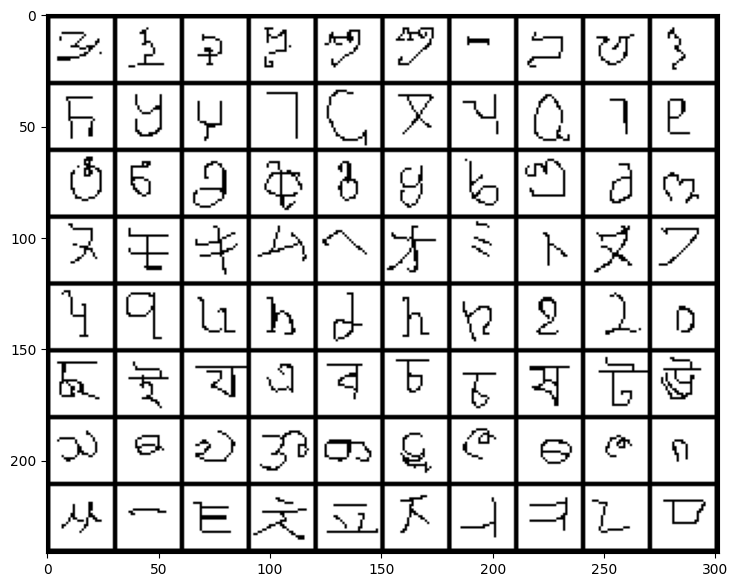

In [119]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [126]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProtoNetEncoder(nn.Module):
    def __init__(self, input_channels=3, hidden_channels=64):
        super(ProtoNetEncoder, self).__init__()
        
        # Каждый блок: Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d(2x2)
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
    def forward(self, sample):
    # sample: (n_way, n_classes, C, H, W)
        n_way, n_classes, c, h, w = sample.shape

        # Преобразуем в (n_way * n_classes, C, H, W)
        x = sample.view(n_way * n_classes, c, h, w)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Флэттим вектора признаков: (n_way * n_classes, 64)
        x = torch.flatten(x, start_dim=1)

        # Возвращаем в (n_way, n_classes, 64)
        x = x.view(n_way, n_classes, -1)

        return x


### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [142]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (dict): {'images': Tensor, 'n_way': int, 'n_support': int, 'n_query': int}
        Returns:
            (loss, dict): loss tensor and dictionary with 'loss', 'acc', 'y_hat'
        """
        x = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        device = next(self.parameters()).device
        x = x.to(device)

        # 1. Получаем эмбеддинги
        emb = self.encoder(x)  # (n_way * (n_support + n_query), D)
        D = emb.size(-1)
        emb = emb.view(n_way, n_support + n_query, D)

        emb_support = emb[:, :n_support, :]  # (n_way, n_support, D)
        emb_query   = emb[:, n_support:, :]  # (n_way, n_query, D)

        # 2. Вычисляем прототипы
        prototypes = emb_support.mean(1)  # (n_way, D)

        # 3. Расстояния между каждым запросом и всеми прототипами
        emb_query = emb_query.contiguous().view(n_way * n_query, D)  # (n_way*n_query, D)
        dists = torch.cdist(emb_query, prototypes)  # (n_way*n_query, n_way)

        # 4. Вероятности через softmax
        log_p_y = F.log_softmax(-dists, dim=1)  # минус расстояния → ближе = больше лог-проб.

        # 5. Ground-truth метки: 0,1,...,n_way-1 для каждого класса
        y_gt = torch.arange(n_way).unsqueeze(1).expand(n_way, n_query).reshape(-1).to(device)  # (n_way*n_query)

        loss_val = F.nll_loss(log_p_y, y_gt)
        y_hat = log_p_y.argmax(1)
        acc_val = (y_hat == y_gt).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
        }

In [130]:
def load_protonet_conv(x_dim, hid_dim, z_dim):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = ProtoNetEncoder() # your code
    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [146]:
os.environ['WANDB_MODE'] = 'offline'
import wandb


def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    device = next(model.parameters()).device  # cuda / cpu

    wandb.watch(model, log="all", log_freq=100)  # градиенты и параметры

    for epoch in range(max_epoch):
        running_loss, running_acc = 0.0, 0.0

        # tqdm-прогресс с live-loss
        prog_bar = tnrange(epoch_size, desc=f"Epoch {epoch+1}")
        for _ in prog_bar:
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            # Обеспечиваем, что картинки на том же девайсе, что и модель
            sample["images"] = sample["images"].to(device)

            optimizer.zero_grad()
            loss, out = model.set_forward_loss(sample)
            loss.backward()
            optimizer.step()

            running_loss += out["loss"]
            running_acc  += out["acc"]

            # Обновляем строку состояния tqdm
            prog_bar.set_postfix(loss=f"{out['loss']:.4f}")

        # Средние метрики за эпоху
        epoch_loss = running_loss / epoch_size
        epoch_acc  = running_acc  / epoch_size
        lr_now = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1:02d} -- Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}  LR: {lr_now:.6f}")

        # Логируем в wandb
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_acc,
            "lr": lr_now,
        })

        scheduler.step()

    # ─────────────── Сохраняем финальную модель ───────────────
    torch.save(model.state_dict())
    print(f" Model saved")

    wandb.save()

In [ ]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 30
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 2
epoch_size = 2000

Число уникальных классов в train_y: 30


In [155]:
%%time

wandb.init(project="protonet", config={
    "n_way": n_way,
    "n_support": n_support,
    "n_query": n_query,
    "max_epoch": max_epoch,
    "epoch_size": epoch_size,
    "initial_lr": optimizer,
})

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
lr,█▄▂▁▁
accuracy,0.99961
epoch,5
loss,0.01311
lr,6e-05


Epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 -- Loss: 0.8868  Acc: 0.7476  LR: 0.001000


Epoch 2:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 -- Loss: 0.1409  Acc: 0.9715  LR: 0.000500


TypeError: save() missing 1 required positional argument: 'f'

In [ ]:
torch.save(model.state_dict(), "model.pt")
print("Model saved")


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Model saved


True

## Test

In [151]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
        
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [152]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [153]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 1.3669 Acc: 0.5284


## Test on specific example

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [ ]:
# pass your code

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды: 
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.